In [1]:
import copy

import numpy as np
from qiskit import *
from qiskit.extensions import UnitaryGate
from qiskit.circuit.add_control import add_control
from POVMMeasure import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from SequentialPOVMMeasurement import SequentialPOVMMeasurement

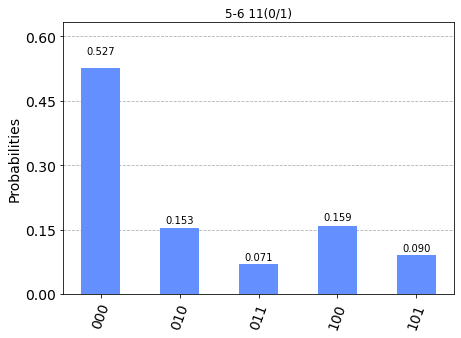

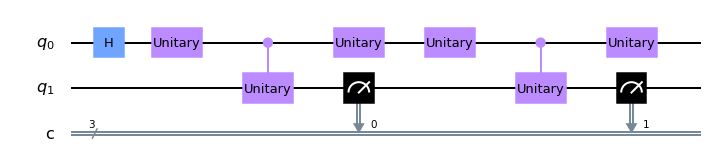

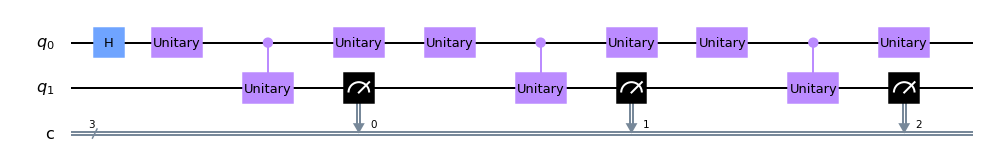

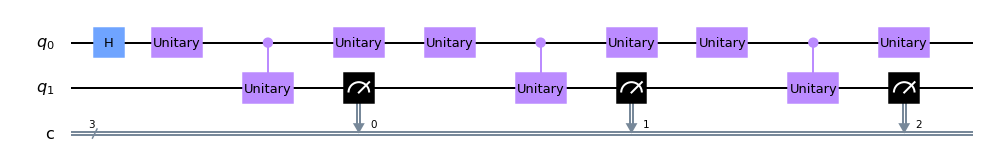

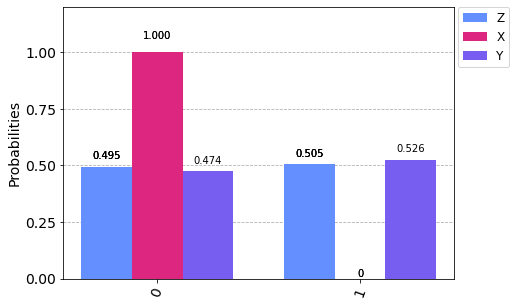

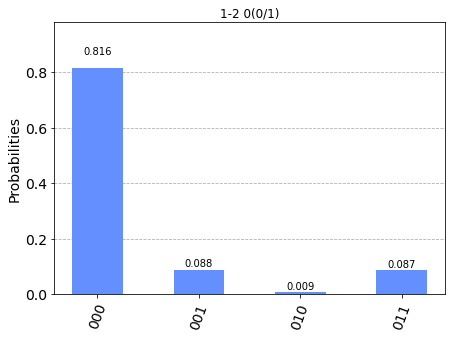

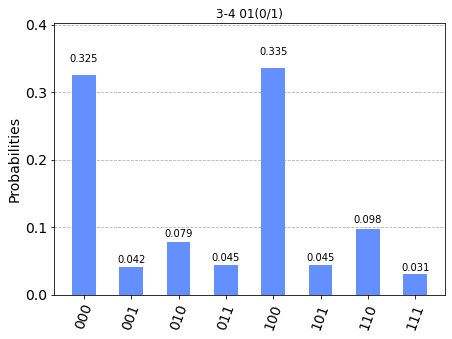

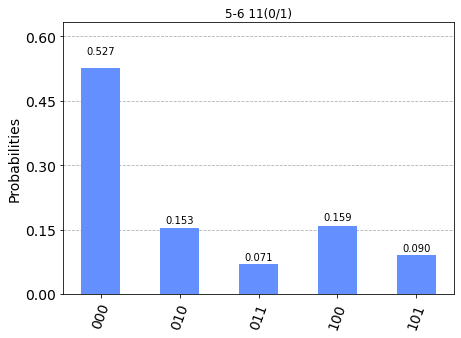

In [2]:

povm_effects = [
    np.array([[1/6, 1/6],
              [1/6, 1/6]]),
    np.array([[1/6, -1/6],
              [-1/6, 1/6]]),
    np.array([[1/6, 0+(-1j/6)],
              [0+(1j/6), 1/6]]),
    np.array([[1/6, 0+(1j/6)],
              [0+(-1j/6), 1/6]]),
    np.array([[1/3, 0],
              [0, 0]]),
    np.array([[0, 0],
              [0, 1/3]])
]

seq = SequentialPOVMMeasurement(povm_effects, [1, 2, 3, 4, 5, 6])
state = QuantumCircuit(1, 1)
state.h(0)
circuits = seq.make_circuits([[1, 2], [[3, 4], [5, 6]]], state)
circuits[0][0].draw('mpl')
circuits[1][0].draw('mpl')
circuits[2][0].draw('mpl')

test_circuit = QuantumCircuit(1,1)
test_circuit.h(0)

z_measure = QuantumCircuit(1,1)
z_measure.measure(0,0)
z_measure = test_circuit + z_measure

y_measure = QuantumCircuit(1,1)
y_measure.sdg(0)
y_measure.h(0)
y_measure.measure(0,0)

y_measure = test_circuit + y_measure

x_measure = QuantumCircuit(1,1)
x_measure.h(0)
x_measure.measure(0,0)

x_measure = test_circuit + x_measure

qasm = qiskit.Aer.get_backend("qasm_simulator")
job_z = qiskit.execute(z_measure, qasm, shots=1000)
job_x = qiskit.execute(x_measure, qasm, shots=1000)
job_y = qiskit.execute(y_measure, qasm, shots=1000)
job_1 = qiskit.execute(circuits[0][0], qasm, shots=1000)
job_2 = qiskit.execute(circuits[1][0], qasm, shots=1000)
job_3 = qiskit.execute(circuits[2][0], qasm, shots=1000)

legend1 = ["Z", "X", "Y"]
plot_histogram([job_z.result().get_counts(), job_x.result().get_counts(), job_y.result().get_counts()], legend=legend1)
plot_histogram(job_1.result().get_counts(), title=circuits[0][1])
plot_histogram(job_2.result().get_counts(), title=circuits[1][1])
plot_histogram(job_3.result().get_counts(), title=circuits[2][1])



[[0.85355339 0.35355339]
 [0.35355339 0.14644661]]
[[ 0.14644661 -0.35355339]
 [-0.35355339  0.85355339]]
[[ 0.14644661 -0.35355339]
 [-0.35355339  0.85355339]]
[[0.85355339 0.35355339]
 [0.35355339 0.14644661]]


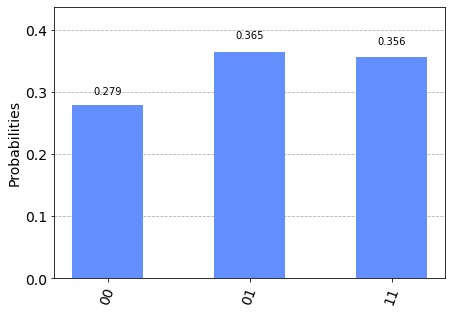

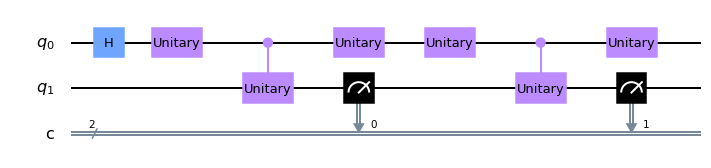

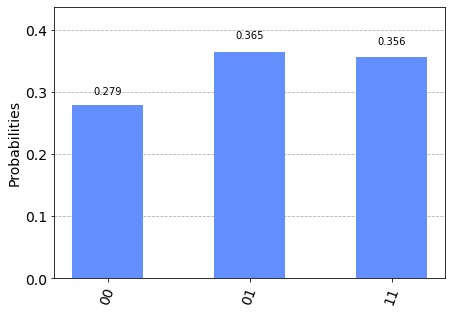

In [26]:
from scipy.linalg import fractional_matrix_power
import copy

def measurement_change(b: np.array, effect: np.array):
    b_pinv = np.linalg.pinv(fractional_matrix_power(b, 0.5))
    return np.matmul(np.matmul(b_pinv, effect), b_pinv)

# povm_effects = [
#     np.array([[1/2, 1/2],
#               [1/2, 1/2]]),
#     np.array([[1/2, -1/2],
#               [-1/2, 1/2]]),
#     np.array([[1/2, 0+(-1j/2)],
#               [0+(1j/2), 1/2]]),
#     np.array([[1/2, 0+(1j/2)],
#               [0+(-1j/2), 1/2]]),
#     np.array([[1, 0],
#               [0, 0]]),
#     np.array([[0, 0],
#               [0, 1]])
# ]

povm_effects = [
    np.array([[1/4, 1/4],
              [1/4, 1/4]]),
    np.array([[1/4, -1/4],
              [-1/4, 1/4]]),
    np.array([[1/4, 0+(-1j/4)],
              [0+(1j/4), 1/4]]),
    np.array([[1/4, 0+(1j/4)],
              [0+(-1j/4), 1/4]]),
    np.array([[1/2, 0],
              [0, 0]]),
    np.array([[0, 0],
              [0, 1/2]])
]

# state = QuantumCircuit(2, 1)
state = QuantumCircuit(2, 2)
state.h(0)

b1 = povm_effects[0]+povm_effects[5]
b2 = povm_effects[1]+povm_effects[4]
a1 = measurement_change(b1, povm_effects[0])
a2 = measurement_change(b1, povm_effects[5])
a3 = measurement_change(b2, povm_effects[1])
a4 = measurement_change(b2, povm_effects[4])
print(a1)
print(a2)
print(a3)
print(a4)


# testing_luder = state + seq.luder_measurement(povm_effects[2], 1, 1)
# testing_luder = state + seq.luder_measurement(b1, 1, 2) + seq.luder_measurement(a1, 1, 2)
testing_luder = state + seq.luder_measurement(b2, 1, 2, measuring_clbit=0) + seq.luder_measurement(a4, 1, 2, measuring_clbit=1)

testing_luder.draw('mpl')
job_1 = qiskit.execute(testing_luder, qasm, shots=1000)
plot_histogram(job_1.result().get_counts())